In [1]:
import numpy as np
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
import time
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


In [2]:
height = 512
width =512
content_image_path = '/Users/user/AuDev/artistic_style_transfer/outing.jpg'
style_image_path = '/Users/user/AuDev/artistic_style_transfer/picasso.jpeg'

content_weight = 0.03
style_weight = 5.0
total_variation_weight = 1.0

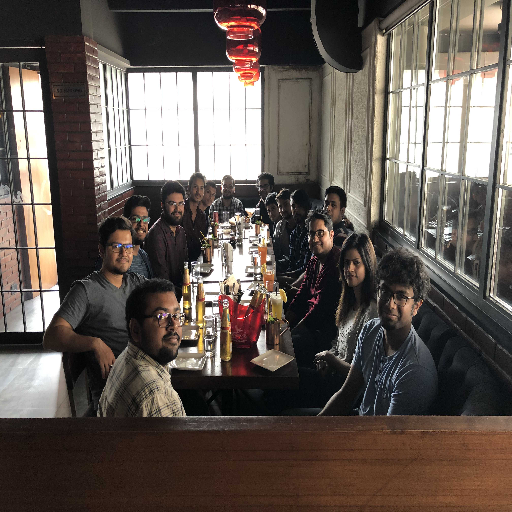

In [3]:
content_image = Image.open(content_image_path)
content_image = content_image.resize((width,height))
content_image

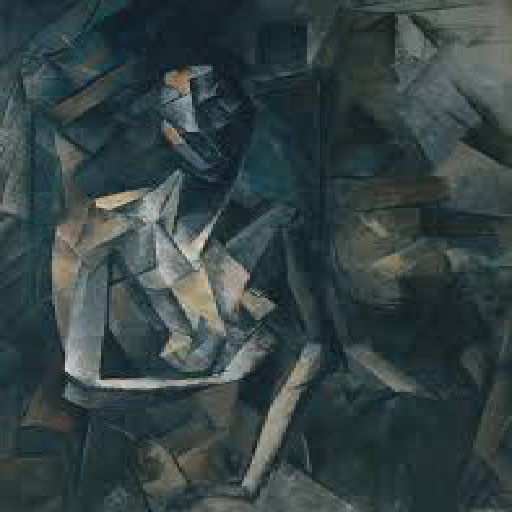

In [4]:
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

In [5]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [6]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [7]:
content_image = K.variable(content_array)
style_image = K.variable(style_array)
combination_image = K.placeholder((1, height, width, 3))

In [8]:
input_tensor = K.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)


In [9]:
model = VGG16(include_top = False,input_tensor= input_tensor, weights = 'imagenet')
model.summary()
layers = dict([(layer.name, layer.output) for layer in model.layers])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [10]:
def content_loss(content, combination):
    return K.sum(K.square(combination - content))
loss = K.variable(0.)

In [11]:
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

In [12]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [13]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


In [14]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [15]:
def total_variation_loss(x):
    a = K.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [16]:
grads = K.gradients(loss, combination_image)

In [17]:
outputs = [loss]
outputs += grads
f_outputs = K.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values


In [18]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [19]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 20

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    x = x.reshape((height, width, 3))
    x = x[:, :, ::-1]
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = np.clip(x, 0, 255).astype('uint8')
    
    img = Image.fromarray(x)
    img.save('generated_pio_{}.jpg'.format(i))

    

Start of iteration 0
Current loss value: 38540136000.0
Iteration 0 completed in 422s
Start of iteration 1
Current loss value: 35449670000.0
Iteration 1 completed in 418s
Start of iteration 2
Current loss value: 37530470000.0
Iteration 2 completed in 416s
Start of iteration 3
Current loss value: 38435410000.0
Iteration 3 completed in 409s
Start of iteration 4
Current loss value: 38227788000.0
Iteration 4 completed in 406s
Start of iteration 5
Current loss value: 37381054000.0
Iteration 5 completed in 430s
Start of iteration 6
Current loss value: 37428724000.0
Iteration 6 completed in 442s
Start of iteration 7
Current loss value: 36904903000.0
Iteration 7 completed in 442s
Start of iteration 8
Current loss value: 37143405000.0
Iteration 8 completed in 431s
Start of iteration 9
Current loss value: 36793655000.0
Iteration 9 completed in 441s
Start of iteration 10
Current loss value: 37015900000.0
Iteration 10 completed in 391s
Start of iteration 11
Current loss value: 36850442000.0
Iterati

In [20]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')


In [21]:

img = Image.fromarray(x)
img.save('generated.jpg')

In [ ]:
Image.save()